# Praca domowa nr 7
Adrianna Grudzień\
14.06.2021 r.

W ramach pracy domowej z przedmiotu Wstęp do uczenia maszynowego wykorzytałam `algorytm GMM` do wykrywania próbek odstających.
Do oceny modelu użyłam metryk F1 score, Precision i Recall.

Poniższe zbiory zostały wyodrębnione ze zbioru [Wine UCI](https://archive.ics.uci.edu/ml/datasets/wine):
- train - bez próbek odstających, do trenowania modelu
- test - do oceny skuteczności modelu, dodana informacja o klasie 0=inliers, 1=outliers
- val - analogiczny do test, ale bez klasy

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import f1_score, precision_score, recall_score

In [179]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')

In [180]:
test.head(3)

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,0,13.34,0.94,2.36,17.0,110,2.53,1.30,0.55,0.42,3.17,1.02,1.93,750
1,0,12.00,0.92,2.00,19.0,86,2.42,2.26,0.30,1.43,2.50,1.38,3.12,278
2,0,11.84,0.89,2.58,18.0,94,2.20,2.21,0.22,2.35,3.05,0.79,3.08,520


Rozdzielam klasę od zbioru testowego.

In [181]:
klasa = test['class']
test = test.drop('class', axis=1)
test.head(3)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,13.34,0.94,2.36,17.0,110,2.53,1.30,0.55,0.42,3.17,1.02,1.93,750
1,12.00,0.92,2.00,19.0,86,2.42,2.26,0.30,1.43,2.50,1.38,3.12,278
2,11.84,0.89,2.58,18.0,94,2.20,2.21,0.22,2.35,3.05,0.79,3.08,520


In [182]:
klasa

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    1
13    1
14    1
15    1
16    1
Name: class, dtype: int64

### Liczba wartości odstających

In [183]:
print('W zbiorze jest',klasa.sum(), 'wartości odstających.')

W zbiorze jest 5 wartości odstających.


# Wybór liczby komponentów

Fakt, że GMM jest modelem generatywnym, daje nam naturalny sposób na określenie optymalnej liczby komponentów dla danego zbioru danych. Model generatywny jest z natury rozkładem prawdopodobieństwa dla zbioru danych, więc możemy po prostu ocenić prawdopodobieństwo danych w modelu, używając walidacji krzyżowej, aby uniknąć nadmiernego dopasowania. Innym sposobem korygowania nadmiernego dopasowania jest dostosowanie prawdopodobieństw modelu za pomocą pewnego kryterium analitycznego, takiego jak kryterium informacyjne Akaike (AIC) lub kryterium informacyjne Bayesa (BIC). Estymator GMM firmy Scikit-Learn w rzeczywistości zawiera wbudowane metody, które obliczają oba te elementy.

Skorzystam z kryterium BIC (Bayesian information criterion).

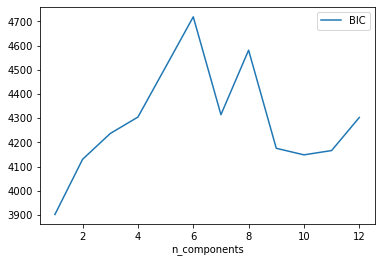

In [184]:
bic = []
# aic = []
n = 13
for i in range(1, n):
    gmm = GaussianMixture(n_components = i, random_state = 42, covariance_type = "full")
    gmm.fit(train)
    bic.append(gmm.bic(train))
#     aic.append(gmm.aic(train))

plt.plot(range(1,n), bic, label='BIC')
# plt.plot(range(1,n), aic, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()

Źródła: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

Wybieram liczbę komponentów, przy której funkcja osiąga minimum. W tym przypadku jest to liczba 1.

In [201]:
gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=42).fit(train)

# Wybór tresholdu

In [202]:
train_score = gmm.score_samples(train)
train_score

array([-16.11433629, -16.24072663, -17.01319953, -18.53216451,
       -15.41980729, -17.02567806, -20.62755692, -30.16511221,
       -15.87223657, -13.15813475, -16.5537263 , -21.65120826,
       -18.6754991 , -15.40723157, -15.83935145, -18.51395884,
       -16.34631529, -17.19295309, -15.05451269, -15.10925767,
       -18.3293234 , -16.21830116, -16.52153899, -16.17521872,
       -17.55833929, -17.05622934, -16.10603533, -20.91012001,
       -15.67894179, -17.82279723, -28.30009176, -15.99565493,
       -16.49666138, -17.66940234, -18.8621301 , -16.41508755,
       -18.84280997, -17.33271727, -20.39825377, -18.51097736,
       -13.93796963, -17.18712056, -16.66823296, -15.65827134,
       -15.68265414, -16.18083342, -24.26800554, -18.10968611,
       -35.63214562, -19.55053039, -23.36893287, -18.66743755,
       -16.96489625, -21.5739571 , -17.53747276, -14.73124816,
       -18.13769963, -18.74700277, -22.80200584, -16.83219175,
       -15.48375733, -20.80138758, -14.35628214, -18.42

In [203]:
treshold = (np.floor(min(train_score)), np.ceil(max(train_score)))
print('Treshold:', treshold)

Treshold: (-36.0, -13.0)


In [204]:
test_score=gmm.score_samples(test) 
test_score

array([-27.98408339, -16.00062629, -25.18813464, -33.08470866,
       -26.091527  , -16.56657131, -15.6694633 , -24.56470654,
       -17.76619681, -15.00916902, -15.6122348 , -15.96698264,
       -38.46599555, -32.74787752, -34.97227525, -69.70978568,
       -54.71878434])

In [205]:
val_score = gmm.score_samples(val)
val_score

array([-24.10959418, -13.65630606, -18.34880196, -24.73181233,
       -26.57221749, -15.40885949, -17.54071457, -44.68237109,
       -23.49812295, -16.62083415, -23.70650304, -18.9538749 ,
       -32.17842524, -19.9733441 , -23.6015326 , -16.07247901,
       -50.96461189])

In [213]:
outliers_val = []
for i in val_score:
    if i < treshold[0] or i > treshold[1]:
        outliers_val.append(1)
    else:
        outliers_val.append(0)
        
print('Wartości odstające:', outliers_val)
print('Liczba tych wartości:', sum(outliers_val))

Wartości odstające: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Liczba tych wartości: 2


In [214]:
outliers_test = []
for i in test_score:
    if i < treshold[0] or i > treshold[1]:
        outliers_test.append(1)
    else:
        outliers_test.append(0)

print('Wartości odstające:', outliers_test)
print('Liczba tych wartości:', sum(outliers_test))

df = pd.DataFrame()
df['oryginalnie'] = klasa
df['przewidywane'] = outliers_test
df

Wartości odstające: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1]
Liczba tych wartości: 3


,oryginalnie,przewidywane
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


Jak widać, zostały wykryte tylko 3 z 5 wartości odstających.

In [219]:
print("F1 score:", f1_score(klasa, outliers_test))
print("Precision score:", precision_score(klasa, outliers_test))
print("Recall score:", recall_score(klasa, outliers_test))

F1 score: 0.7499999999999999
Precision score: 1.0
Recall score: 0.6


Wyniki są całkiem niezłe.
# Wnioski
Przy stosowaniu algorytmu GMM ważny jest odpowiedni dobór hiperparametrów, gdyż może to znacząco zmienić wyniki metryk. W analizowanym przypadku F1 score jest na wysokim poziomie (najwyższa i tym samym najlepsza wartośc wynosi 1, a tutaj mamy 0.75). Precision score wyższe być nie mogłoby (przyjmuje wartości z [0,1], gdzie 1 - najlepsza precyzja); recall score przyjmuje wartość 0.6, co odwzorowuje 3 na 5 dobrze wykrytych wartości odstających. Podsumowując, mogę powiedzieć, że GMM jest dobrą metodą wykrywania danych odstających.